In [128]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import BatchNorm1d, ReLU, Linear, Sequential
import numpy as np
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GINConv, global_add_pool
import os
from torch_geometric.loader import DataLoader
import networkx as nx
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from torch_geometric.transforms import NormalizeFeatures

from src.data.peptides_functional import PeptidesFunctionalDataset

from src.models.models import *

from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

In [56]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
dataset = PeptidesFunctionalDataset("/home/zluo/nn/LR-GNN/test/testdata/")
idx_lst = np.random.choice([i for i in range(len(dataset))], size=500, replace=False)
dataset = dataset[idx_lst]

Processing...


Converting SMILES strings into graphs...


 42%|████▏     | 6459/15535 [00:20<00:31, 290.17it/s][18:24:44] WARNING: not removing hydrogen atom without neighbors
[18:24:44] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 15535/15535 [00:49<00:00, 313.14it/s]


Saving...


Done!


In [120]:
Y = []
for data in dataset:
    Y.append(data.y.tolist()[0])
    
new_data = [list(y) for y in set([tuple(x) for x in Y])]

n_class = len(new_data)

In [121]:
input_channels = dataset.num_node_features
hidden_channels = 32
output_channels = n_class

In [122]:
data

Data(edge_index=[2, 264], edge_attr=[264, 3], x=[127, 9], y=[1, 10])

In [123]:
one_hot = []
for y in Y:
    to_add = [0 for idx in range(n_class)]
    to_add[new_data.index(y)] = 1
    one_hot.append(to_add)
    continue

In [124]:
data_lst = []
for idx in range(len(dataset)):
    data = dataset[idx]
    data.y = torch.FloatTensor([one_hot[idx]])
    data_lst.append(data)

In [137]:
old_avg_length = []

for idx in range(len(data_lst)):
    d = data_lst[idx]
    g1 = nx.Graph(d.edge_index.T.tolist())
    try:
        old_avg_length.append(nx.average_shortest_path_length(g1))
    except:
        print("not connected")

not connected
not connected
not connected
not connected
not connected


Text(0, 0.5, 'Frequency')

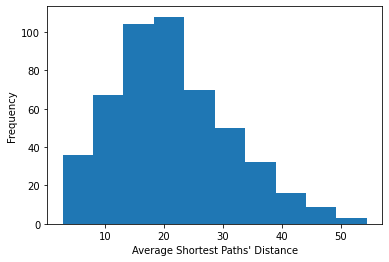

In [141]:
plt.hist(old_avg_length)
plt.xlabel("Average Shortest Paths' Distance")
plt.ylabel("Frequency")

In [ ]:
new_data_lst = random_shortcuts(data_lst)

In [139]:
new_avg_length = []

for idx in range(len(new_data_lst)):
    d = new_data_lst[idx]
    g1 = nx.Graph(d.edge_index.T.tolist())
    try:
        new_avg_length.append(nx.average_shortest_path_length(g1))
    except:
        print("not connected")

Text(0, 0.5, 'Frequency')

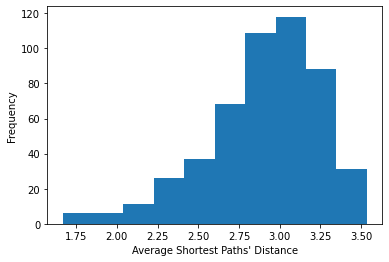

In [142]:
plt.hist(new_avg_length)
plt.xlabel("Average Shortest Paths' Distance")
plt.ylabel("Frequency")

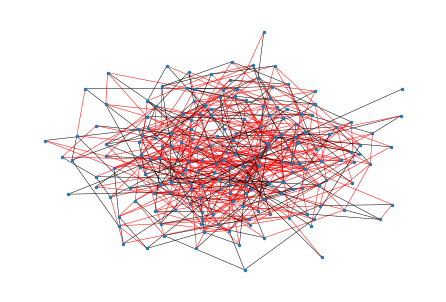

In [11]:
d = data_lst[0]
g1 = nx.Graph(d.edge_index.T.tolist())
color_lst = []
for edg in list(g1.edges):
    if edg in old_edgs:
        color_lst.append("black")
    else:
        color_lst.append("red")
nx.draw(g1, node_size=6, width=0.5, edge_color=color_lst)

In [12]:
nx.average_shortest_path_length(g1)

3.084371327849589

In [10]:
for data in data_lst:
    edgelist = data.edge_index.T.numpy()
    new_edgelist = []

    while len(new_edgelist) <= len(edgelist): 
        n = data.x.shape[0]
        a = np.random.choice(n)
        b = np.random.choice(n)
        if a == b:
            continue

        new_edgelist.append([a, b])

    edgelist = torch.LongTensor(np.concatenate([edgelist, new_edgelist]).T)
    data.edge_index = edgelist

In [310]:
model = GCN(16, input_channels, output_channels)

In [311]:
train_set, val_set = torch.utils.data.random_split(data_lst, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(val_set, batch_size=10, shuffle=False)

In [312]:
def train():
    model.train()

    for data in train_loader:
        # Iterate in batches over the training dataset.
        out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    loss_total = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float(), data.edge_index, data.batch)  
        loss = average_precision_score(data.y.numpy()[0], out.detach().numpy()[0])
        loss_total += loss
    return loss_total / len(loader.dataset)  # Derive ratio of correct predictions.

In [313]:
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_acc:.4f}, Test Loss: {test_acc:.4f}\n')

Epoch: 001, Train Loss: 0.0272, Test Loss: 0.0416

Epoch: 002, Train Loss: 0.0337, Test Loss: 0.0417

Epoch: 003, Train Loss: 0.0407, Test Loss: 0.0417

Epoch: 004, Train Loss: 0.0389, Test Loss: 0.0417

Epoch: 005, Train Loss: 0.0433, Test Loss: 0.0402

Epoch: 006, Train Loss: 0.0525, Test Loss: 0.0402

Epoch: 007, Train Loss: 0.0331, Test Loss: 0.0402

Epoch: 008, Train Loss: 0.0396, Test Loss: 0.0419

Epoch: 009, Train Loss: 0.0387, Test Loss: 0.0402

Epoch: 010, Train Loss: 0.0406, Test Loss: 0.0402

Epoch: 011, Train Loss: 0.0391, Test Loss: 0.0402

Epoch: 012, Train Loss: 0.0372, Test Loss: 0.0402

Epoch: 013, Train Loss: 0.0320, Test Loss: 0.0402

Epoch: 014, Train Loss: 0.0449, Test Loss: 0.0402

Epoch: 015, Train Loss: 0.0241, Test Loss: 0.0402

Epoch: 016, Train Loss: 0.0360, Test Loss: 0.0402

Epoch: 017, Train Loss: 0.0370, Test Loss: 0.0402

Epoch: 018, Train Loss: 0.0368, Test Loss: 0.0402

Epoch: 019, Train Loss: 0.0351, Test Loss: 0.0402

Epoch: 020, Train Loss: 0.0389,

In [64]:
from src.data.test import load_dataset
from src.models.models import *
import json

In [65]:
with open('config/test-params.json') as fh:
    test_params = json.load(fh)

In [68]:
data_lst, input_channels, output_channels = load_dataset(**test_params)

start testing loading the PyG dataset
Dataset loaded and shuffled!


In [69]:
from src.process.algorithms import random_shortcuts

In [71]:
new_data_lst = random_shortcuts(data_lst)

In [106]:
model = GCN(input_channels, 16, output_channels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [116]:
from src.utils.utils import *

In [117]:
run(model, data_lst, 0.8, criterion, optimizer, 10, 10)

Split data list to train and val datasets
Training settings:
    Dataset size: 500 
    Train set size: 400  
    Val set size: 100 
    Epoch setting: 10 
    Batch size: 10 
<<<Training Started!!>>>
Epoch: 001, Train Loss: 0.0418, Val Loss: 0.0336

Epoch: 002, Train Loss: 0.0341, Val Loss: 0.0307



KeyboardInterrupt: 